In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import scipy
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

In [72]:
# dir for mac

sst_file_dir = "/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/OISST/northeast_sst.nc"
prec_file_dir = "/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/TRMM/northeast_precip.nc"

In [73]:
sst_oisst = xr.open_dataarray(sst_file_dir)

sst_oisst = sst_oisst.loc[0: 8034,:, :]

precip = xr.open_dataarray(prec_file_dir)

In [74]:
sst_oisst

<xarray.DataArray 'sst' (time: 8034, lat: 122, lon: 122)>
[119578056 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -40.12 -39.88 -39.62 -39.38 ... -10.38 -10.12 -9.875
  * lon      (lon) float64 139.9 140.1 140.4 140.6 ... 169.4 169.6 169.9 170.1
  * time     (time) float64 1.0 2.0 3.0 4.0 ... 8.032e+03 8.033e+03 8.034e+03

In [ ]:
date_time = pd.date_range(start='1998-01-01', periods=8034, freq='D')

In [76]:
sst_oisst['time'] = date_time

precip['time'] = date_time

In [77]:
precip_box_01 = precip.sel(lat=slice(-40,-37), lon=slice(150,153))


sst_oisst_box_01 = sst_oisst.sel(lat=slice(-40,-37), lon=slice(150,153))

In [78]:
precip_box_02 = precip.sel(lat=slice(-40,-37), lon=slice(158,161))

sst_oisst_box_02 = sst_oisst.sel(lat=slice(-40,-37), lon=slice(158,161))

In [79]:
precip_box_03 = precip.sel(lat=slice(-40,-37), lon=slice(167,170))

sst_oisst_box_03 = sst_oisst.sel(lat=slice(-40,-37), lon=slice(167,170))

In [ ]:
precip_box_01_values = precip_box_01.values.reshape(8034*12*12)

precip_box_01_values_log = np.log1p(precip_box_01_values)

sst_oisst_box_01_values = sst_oisst_box_01.values.reshape(8034*12*12)

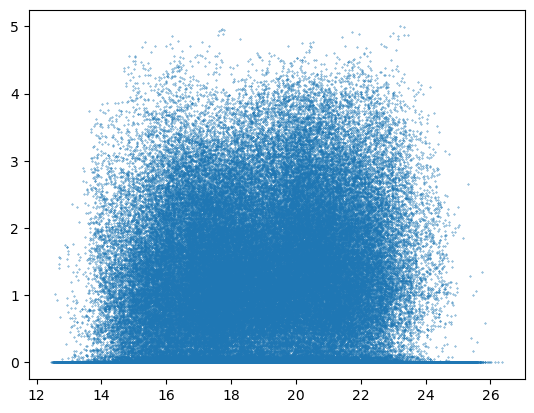

In [81]:
plt.scatter(sst_oisst_box_01_values, precip_box_01_values_log, s=0.1)

In [82]:
def precip_accumulation_on_sst(data, sst_interval, sst_min, sst_max):
    """
    Calculate the accumulation of precipitation on a certain range of sea surface temperature (SST) values.
    data: Pandas DataFrame with columns 'sst' and 'precip'
    """
    # Create bins for SST values
    sst_bins = np.arange(sst_min, sst_max, sst_interval)
    bin_labels = [f'({bin_edge:.1f}, {bin_edge+1:.1f})' for bin_edge in sst_bins[:-1]]
    data['SST_bin'] = pd.cut(data['SST'], bins=sst_bins,right = False, labels=bin_labels)
    accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()
    accumulated_precip['bin_midpoint'] = [bin_edge + 0.5 for bin_edge in range(sst_min, sst_max-1)]
    print("Accumulated Precipitation by SST Bin:")
    print(accumulated_precip)
    
    return accumulated_precip, bin_labels, sst_bins

In [83]:
def bar_plot(accumulated_precip, bin_labels,box_name):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
        width=0.8, edgecolor='black', linewidth=1)
    # Add data labels above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 * height,
                f'{height:.1f}',
                ha='center', va='bottom', rotation=0, fontsize=10)

    plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
    plt.ylabel('Accumulated Precipitation', fontsize=14)
    plt.title('Total Accumulated Precipitation by SST Range_' + box_name , fontsize=16)
    plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
    plt.tight_layout()
    plt.show()

    # Create a line plot to show the trend more clearly
    plt.figure(figsize=(12, 6))
    plt.plot(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
            marker='o', markersize=10, linewidth=2, color='royalblue')

    # Add data labels to each point
    for i, val in enumerate(accumulated_precip['Precipitation']):
        plt.text(accumulated_precip['bin_midpoint'][i], val + 0.05 * val, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=10)

    plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
    plt.ylabel('Accumulated Precipitation', fontsize=14)
    plt.title('Total Accumulated Precipitation by SST Range (Trend)_' + box_name, fontsize=16)
    plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [84]:
def statistical_analysis_plot(data, accumulated_precip,sst_bins, box_name):
    bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
        ('sum', 'sum'),              # Total accumulated precipitation
        ('mean', 'mean'),            # Average precipitation per data point in bin
        ('count', 'count'),          # Number of data points in bin
        ('max', 'max'),              # Maximum precipitation in bin
        ('std', np.std)              # Standard deviation of precipitation in bin
    ]).reset_index()

    # Display the detailed statistics
    print("\nDetailed Statistics for Each SST Bin:")
    print(bin_stats)

        
    # Create a multi-plot figure showing different aspects of the data
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

    # Plot 1: Accumulated precipitation
    axes[0].bar(bin_stats['SST_bin'], bin_stats['sum'], 
            width=0.7, color='royalblue', edgecolor='black', alpha=0.7)
    axes[0].set_ylabel('Accumulated Precipitation', fontsize=12)
    axes[0].set_title('Total Accumulated Precipitation by SST Range_'+box_name, fontsize=14)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Count of data points in each bin
    axes[1].bar(bin_stats['SST_bin'], bin_stats['count'], 
            width=0.7, color='green', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Sea Surface Temperature Range (°C)', fontsize=12)
    axes[1].set_ylabel('Count of Data Points', fontsize=12)
    axes[1].set_title('Number of Observations in Each SST Range_'+box_name, fontsize=14)
    axes[1].set_xticklabels(bin_stats['SST_bin'], rotation=45)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Create a stacked visualization: Precipitation vs SST with bin coloring
    plt.figure(figsize=(14, 8))

    # Create a scatter plot with points colored by SST bin
    # Convert bin labels to numeric for coloring
    unique_bins = data['SST_bin'].unique()
    bin_to_number = {bin_label: i for i, bin_label in enumerate(unique_bins)}
    data['bin_number'] = data['SST_bin'].map(bin_to_number)

    # Scatter plot colored by bin
    scatter = plt.scatter(data['SST'], data['Precipitation'], 
                        c=data['bin_number'], cmap='viridis', 
                        alpha=0.6, s=50, edgecolors='none')

    # Add vertical lines to show bin boundaries
    for bin_edge in sst_bins:
        plt.axvline(x=bin_edge, color='gray', linestyle='--', alpha=0.5)

    # Add legend for the bins
    legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                        labels=unique_bins,
                        title="SST Bins",
                        loc="upper left",
                        bbox_to_anchor=(1.01, 1))
    plt.gca().add_artist(legend1)

    plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
    plt.ylabel('Precipitation', fontsize=14)
    plt.title('Precipitation Distribution by SST with Binning_'+box_name, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Calculate the proportion of total precipitation that falls in each SST bin
    total_precip = bin_stats['sum'].sum()
    bin_stats['percentage'] = (bin_stats['sum'] / total_precip) * 100


    # Normalized precipitation by count (average precipitation per observation in each bin)
    plt.figure(figsize=(12, 6))
    plt.bar(bin_stats['SST_bin'], bin_stats['mean'], 
        width=0.7, color='purple', edgecolor='black', alpha=0.7)
    plt.ylim(0, 2)
    plt.xlabel('Sea Surface Temperature Range (°C)', fontsize=14)
    plt.ylabel('Average Precipitation per Observation', fontsize=14)
    plt.title('Average Precipitation by SST Range_'+box_name, fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    slope, intercept, r_value, p_value, std_err = stats.linregress(accumulated_precip['bin_midpoint'], bin_stats['mean'])

    regression_line = slope * accumulated_precip['bin_midpoint'] + intercept 
    plt.plot(bin_stats['SST_bin'], regression_line, color='red', label='Linear Regression')
    stats_text = (f'Linear Regression Statistics:\n'
                f'Slope: {slope:.4f}\n'
                f'Intercept: {intercept:.4f}\n'
                f'R-squared: {r_value**2:.4f}\n'
                f'P-value: {p_value:.4f}\n'
                f'Standard Error: {std_err:.4f}')

    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


    plt.show()

In [85]:
precip_box_01_values = precip_box_01.values.reshape(8034*12*12)

precip_box_01_values_log = np.log1p(precip_box_01_values)

sst_oisst_box_01_values = sst_oisst_box_01.values.reshape(8034*12*12)

data_box_01 = pd.DataFrame({'SST': sst_oisst_box_01_values, 'Precipitation': precip_box_01_values_log})

In [86]:
accumulated_precip_box_01, bin_labels, sst_bins = precip_accumulation_on_sst(data_box_01, 1, 12, 26)

Accumulated Precipitation by SST Bin:
         SST_bin  Precipitation  bin_midpoint
0   (12.0, 13.0)      22.992144          12.5
1   (13.0, 14.0)     800.253034          13.5
2   (14.0, 15.0)    4236.733461          14.5
3   (15.0, 16.0)   10613.546758          15.5
4   (16.0, 17.0)   16752.370913          16.5
5   (17.0, 18.0)   20556.487526          17.5
6   (18.0, 19.0)   19866.967745          18.5
7   (19.0, 20.0)   21591.038449          19.5
8   (20.0, 21.0)   24080.692509          20.5
9   (21.0, 22.0)   18434.101631          21.5
10  (22.0, 23.0)   11246.304851          22.5
11  (23.0, 24.0)    3670.528436          23.5
12  (24.0, 25.0)     698.877111          24.5


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/1117865337.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()


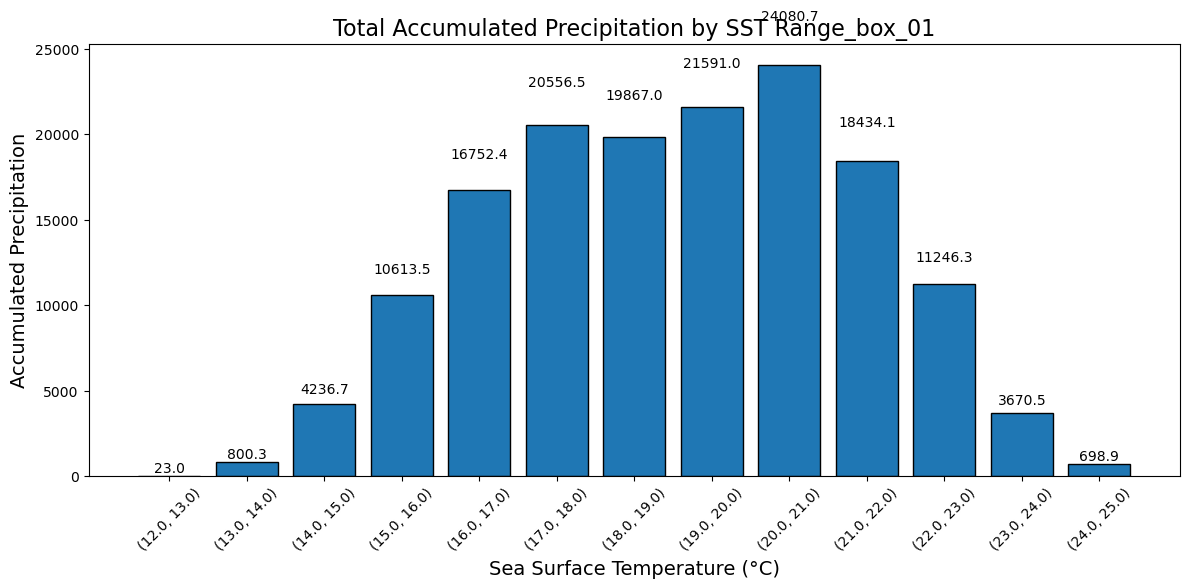

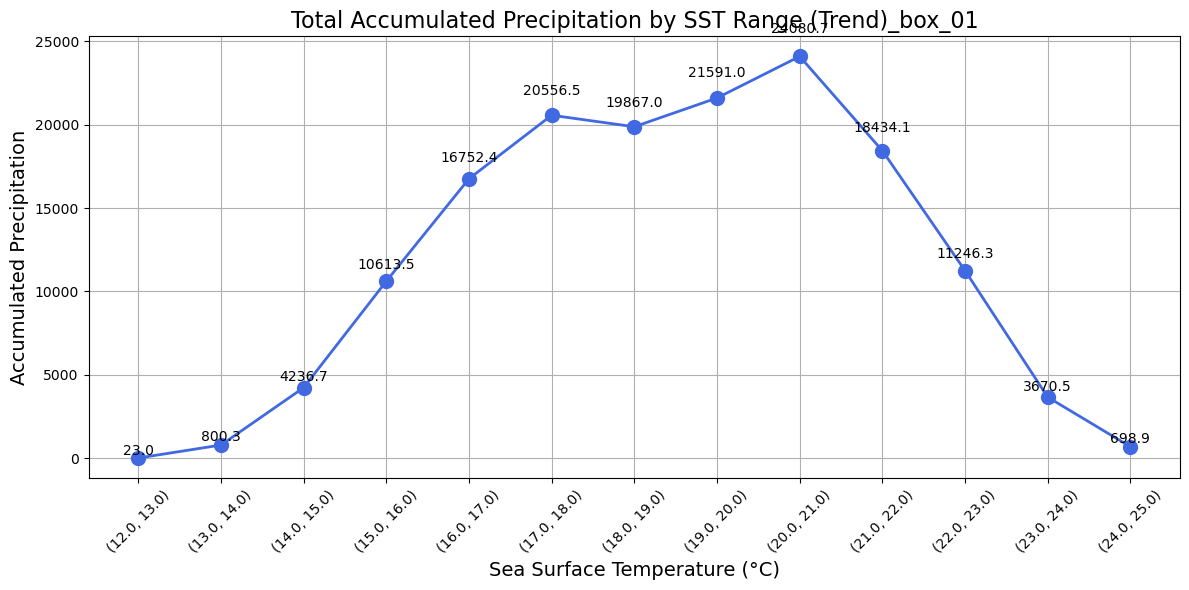

In [87]:
bar_plot(accumulated_precip_box_01, bin_labels, 'box_01')

/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/3067063048.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/3067063048.py:2: FutureWarning: The provided callable <function std at 0x106e28040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/3067063048.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bin_


Detailed Statistics for Each SST Bin:
         SST_bin           sum      mean   count       max       std
0   (12.0, 13.0)     22.992144  0.059258     388  1.742379  0.283032
1   (13.0, 14.0)    800.253034  0.076099   10516  3.763295  0.377742
2   (14.0, 15.0)   4236.733461  0.066752   63470  4.560856  0.341596
3   (15.0, 16.0)  10613.546758  0.082763  128240  4.762657  0.386180
4   (16.0, 17.0)  16752.370913  0.101244  165465  4.852324  0.439689
5   (17.0, 18.0)  20556.487526  0.127156  161663  4.959557  0.481167
6   (18.0, 19.0)  19866.967745  0.136613  145425  4.817128  0.505993
7   (19.0, 20.0)  21591.038449  0.148347  145544  4.711260  0.540225
8   (20.0, 21.0)  24080.692509  0.168414  142985  4.771255  0.582995
9   (21.0, 22.0)  18434.101631  0.173762  106088  4.911378  0.583891
10  (22.0, 23.0)  11246.304851  0.179780   62556  4.862398  0.599185
11  (23.0, 24.0)   3670.528436  0.185662   19770  4.999914  0.616135
12  (24.0, 25.0)    698.877111  0.164597    4246  4.101454  0.54

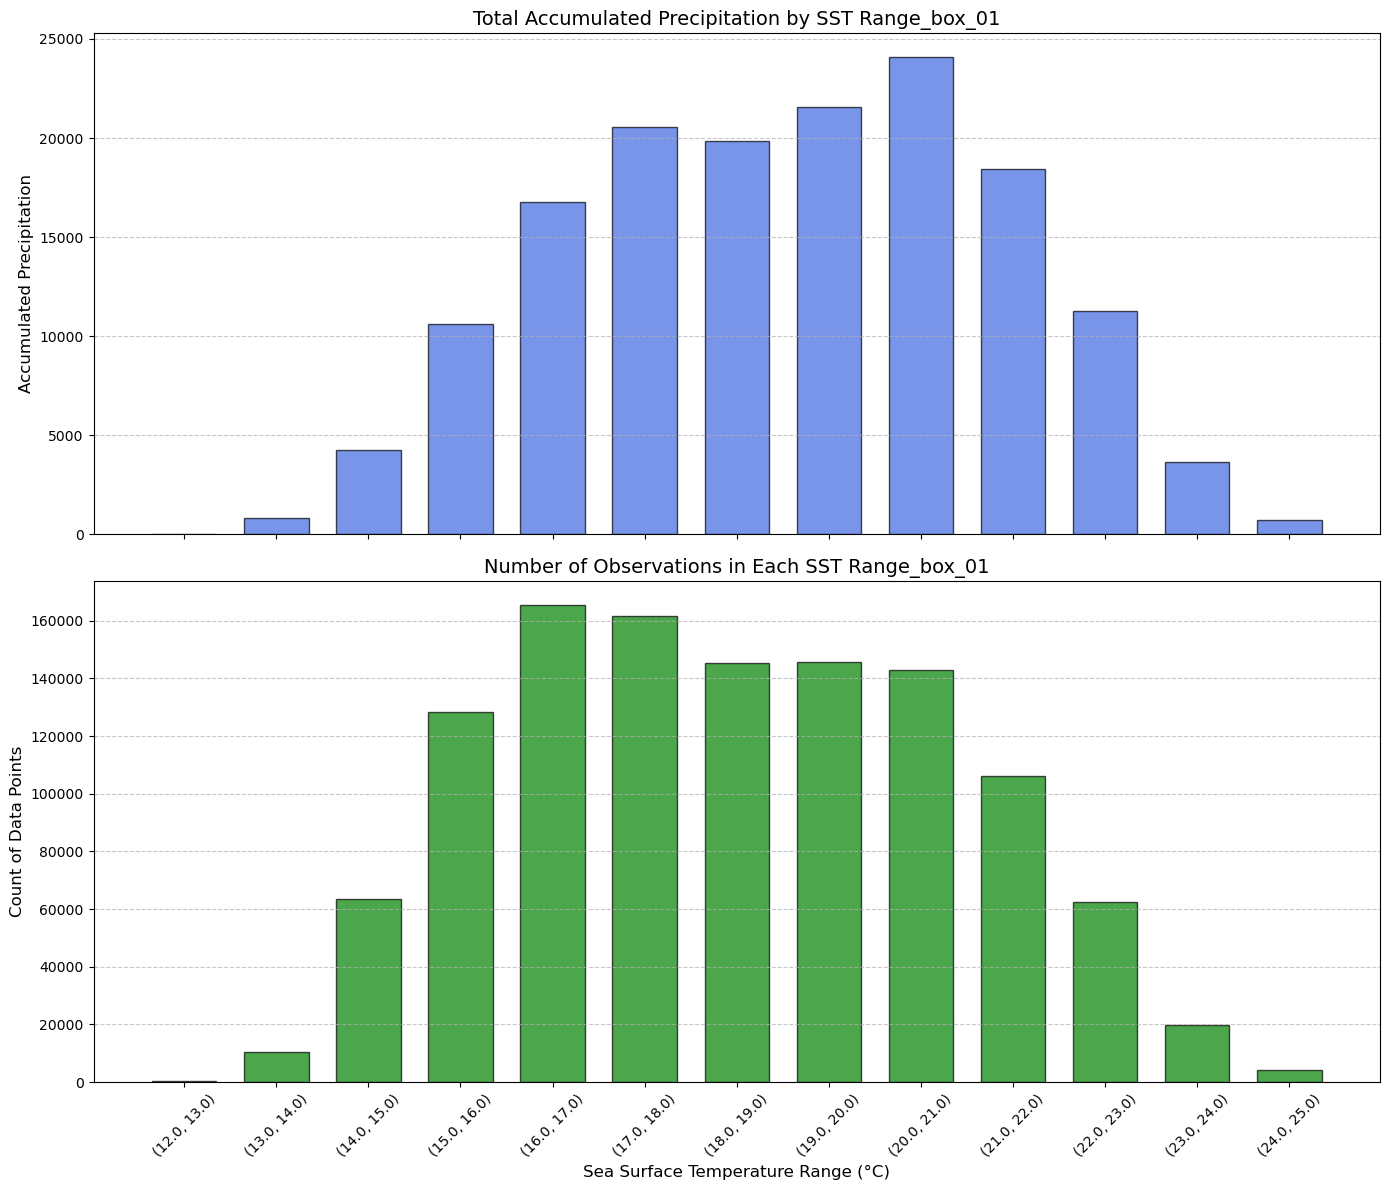

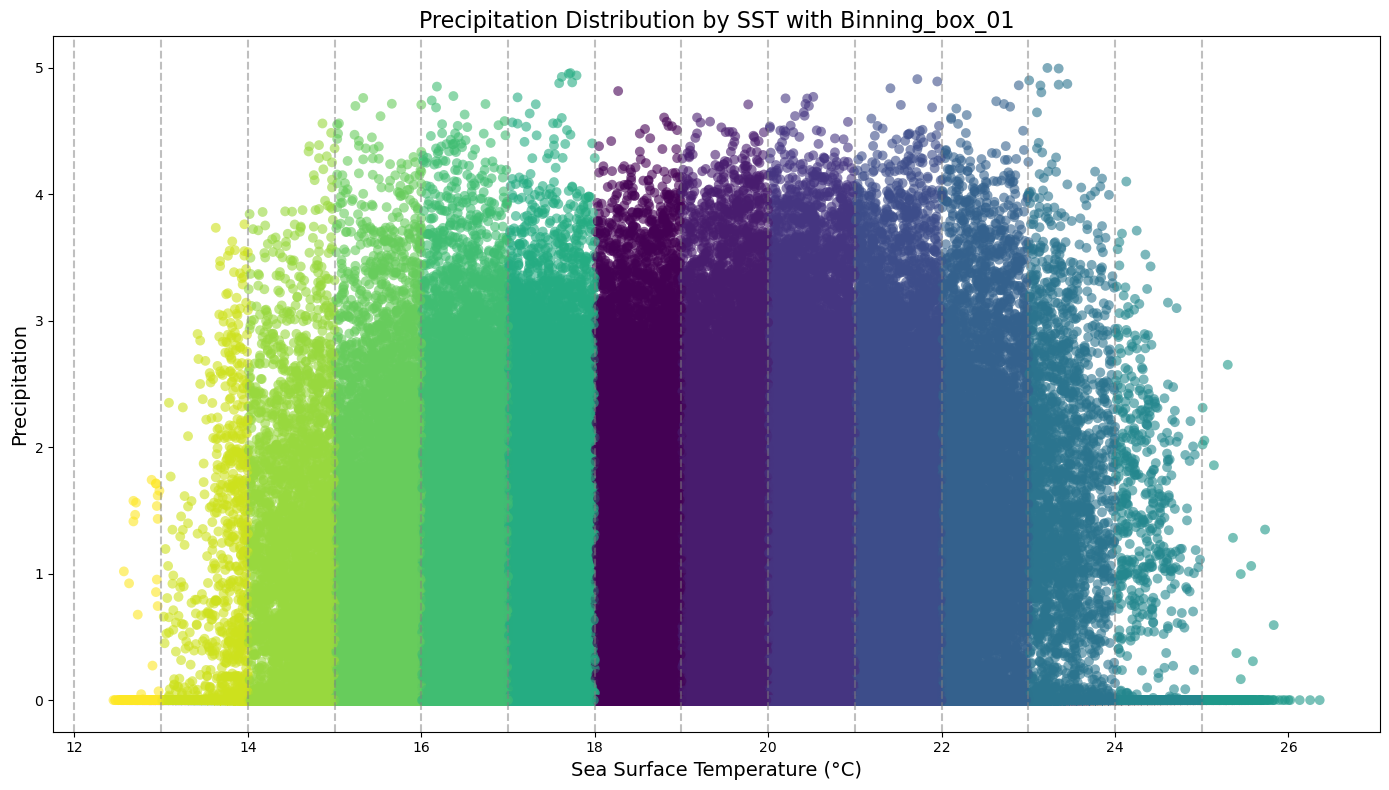

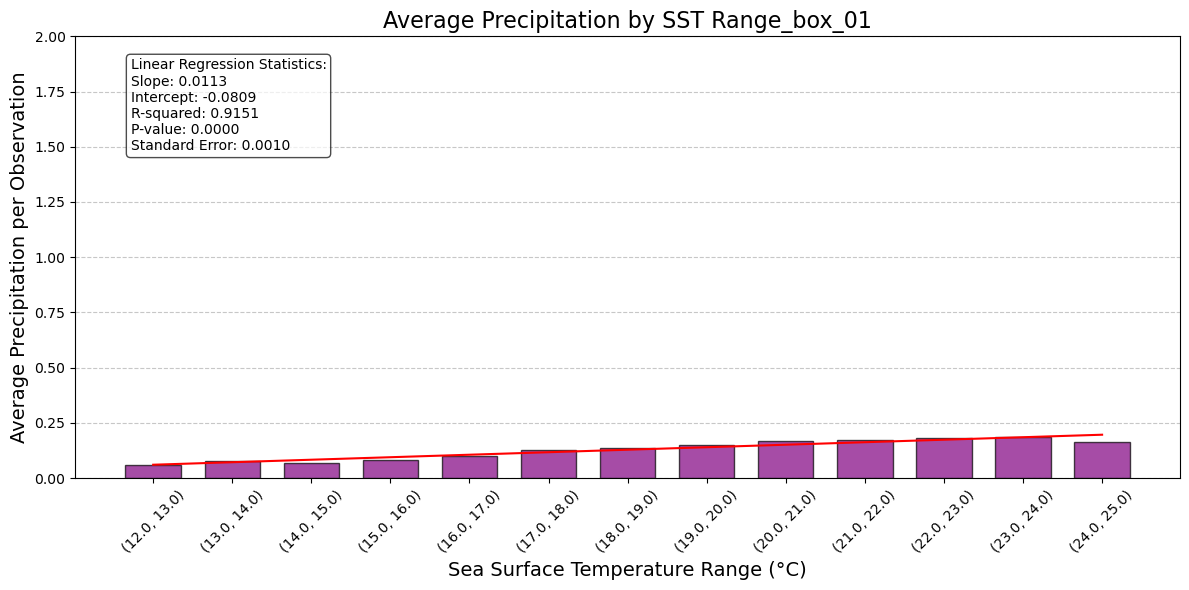

In [88]:
statistical_analysis_plot(data_box_01, accumulated_precip_box_01, sst_bins, 'box_01')

In [89]:
precip_box_02_values = precip_box_02.values.reshape(8034*12*12)

precip_box_02_values_log = np.log1p(precip_box_02_values)

sst_oisst_box_02_values = sst_oisst_box_02.values.reshape(8034*12*12)

data_box_02 = pd.DataFrame({'SST': sst_oisst_box_02_values, 'Precipitation': precip_box_02_values_log})

accumulated_precip_box_02, bin_labels, sst_bins = precip_accumulation_on_sst(data_box_02, 1, 13, 25)

Accumulated Precipitation by SST Bin:
         SST_bin  Precipitation  bin_midpoint
0   (13.0, 14.0)    1203.851558          13.5
1   (14.0, 15.0)    8775.998403          14.5
2   (15.0, 16.0)   20586.528477          15.5
3   (16.0, 17.0)   29562.140949          16.5
4   (17.0, 18.0)   32438.080790          17.5
5   (18.0, 19.0)   45312.649760          18.5
6   (19.0, 20.0)   57991.840251          19.5
7   (20.0, 21.0)   50046.135363          20.5
8   (21.0, 22.0)   31060.808201          21.5
9   (22.0, 23.0)   10656.328654          22.5
10  (23.0, 24.0)    2330.736256          23.5


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/1117865337.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()


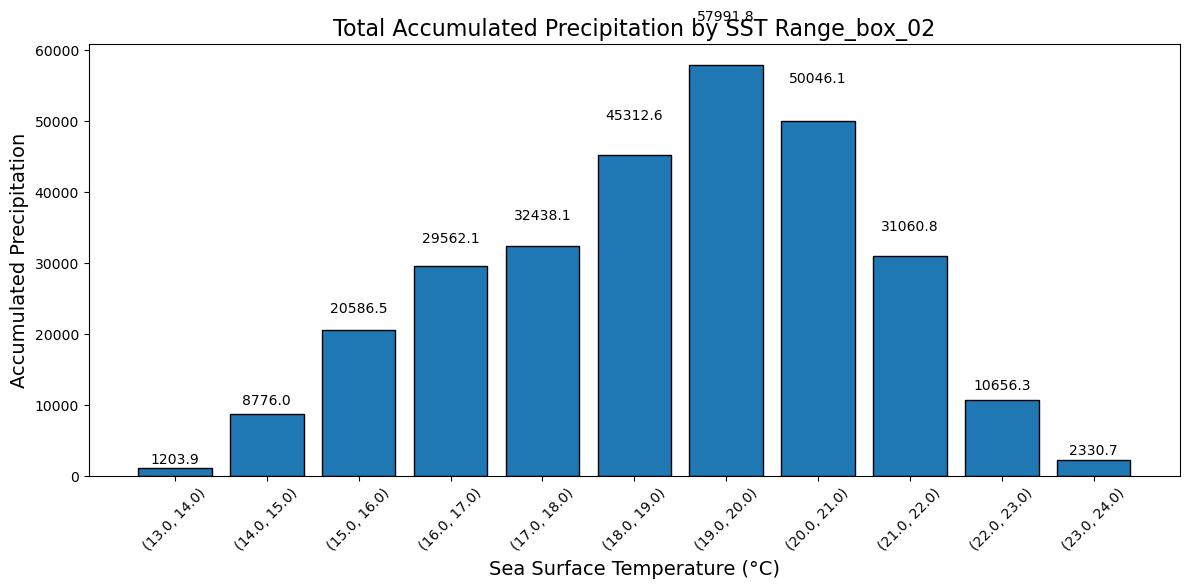

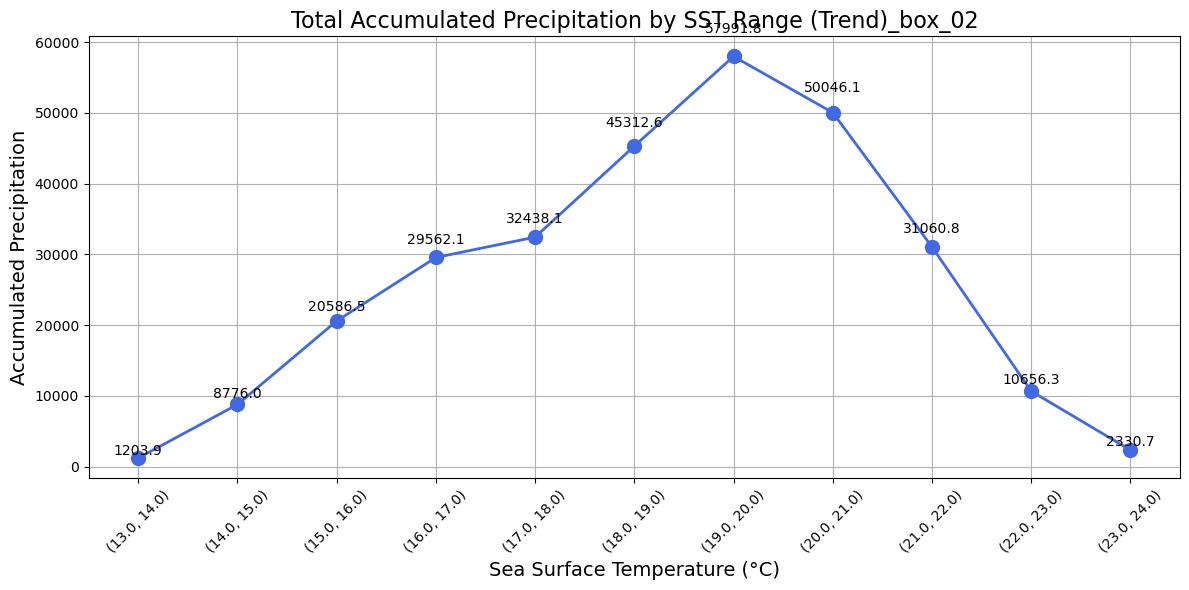

In [90]:
bar_plot(accumulated_precip_box_02, bin_labels, 'box_02')

/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/3067063048.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([



Detailed Statistics for Each SST Bin:
         SST_bin           sum      mean   count       max       std
0   (13.0, 14.0)   1203.851558  0.041195   29223  3.638580  0.278152
1   (14.0, 15.0)   8775.998403  0.063019  139260  4.077321  0.330138
2   (15.0, 16.0)  20586.528477  0.101092  203641  4.447657  0.428395
3   (16.0, 17.0)  29562.140949  0.169177  174741  5.158653  0.575663
4   (17.0, 18.0)  32438.080790  0.234041  138600  5.322673  0.695173
5   (18.0, 19.0)  45312.649760  0.335121  135213  5.355388  0.851073
6   (19.0, 20.0)  57991.840251  0.410800  141168  5.222796  0.931491
7   (20.0, 21.0)  50046.135363  0.443329  112887  5.386768  0.965942
8   (21.0, 22.0)  31060.808201  0.530075   58597  5.239182  1.043246
9   (22.0, 23.0)  10656.328654  0.546086   19514  5.159502  1.085340
10  (23.0, 24.0)   2330.736256  0.742273    3140  5.413861  1.348149


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/3067063048.py:2: FutureWarning: The provided callable <function std at 0x106e28040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/3067063048.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bin_stats['SST_bin'], rotation=45)


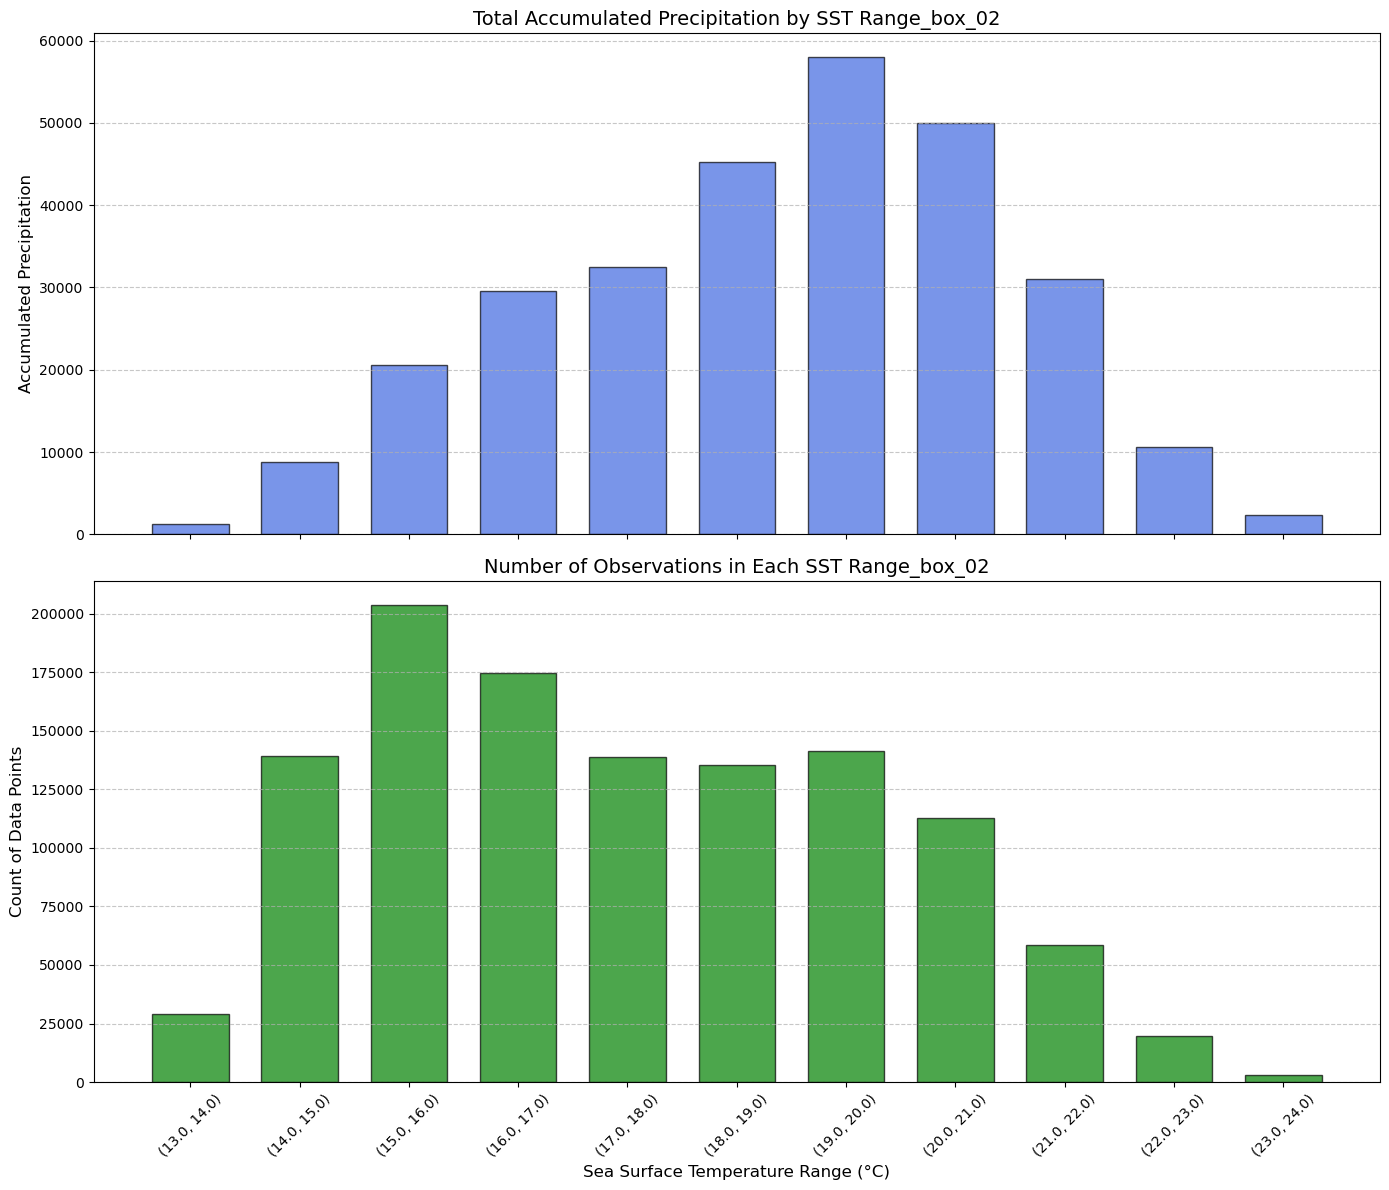

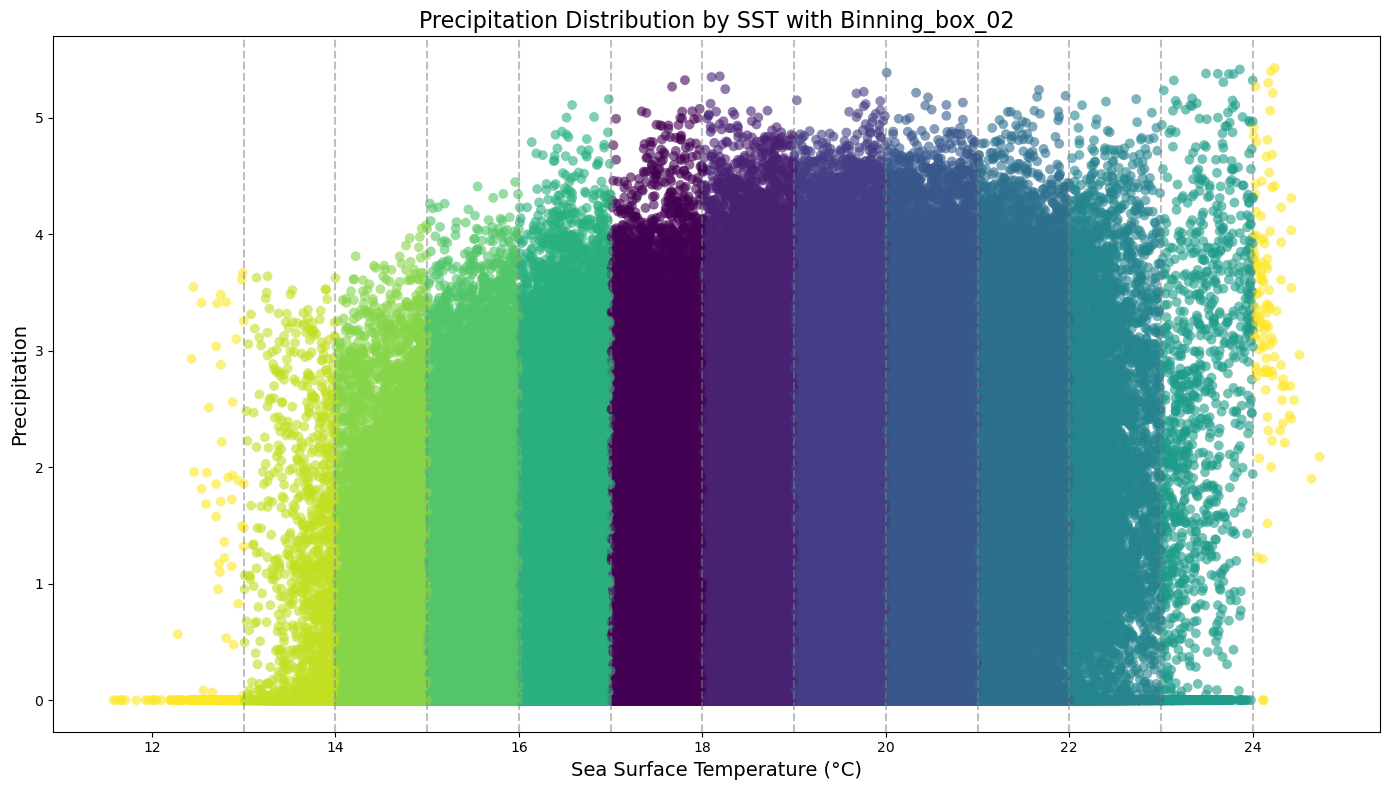

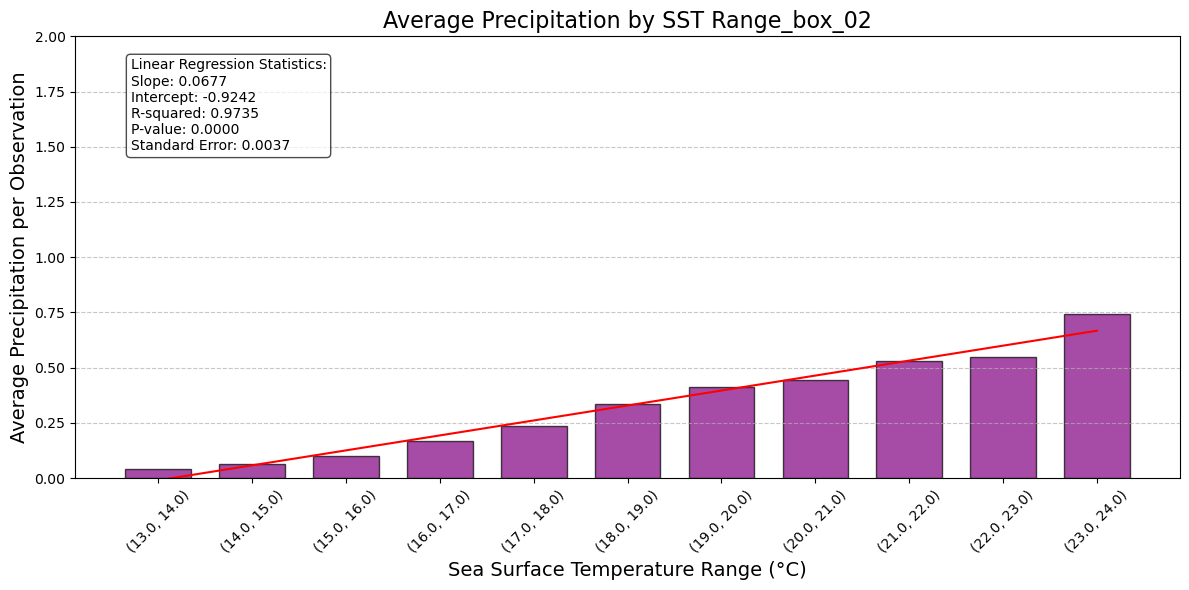

In [91]:
statistical_analysis_plot(data_box_02, accumulated_precip_box_02, sst_bins, 'box_02')

In [92]:
precip_box_03_values = precip_box_03.values.reshape(8034*12*12)

precip_box_03_values_log = np.log1p(precip_box_03_values)

sst_oisst_box_03_values = sst_oisst_box_03.values.reshape(8034*12*12)

data_box_03 = pd.DataFrame({'SST': sst_oisst_box_03_values, 'Precipitation': precip_box_03_values_log})

accumulated_precip_box_03, bin_labels, sst_bins = precip_accumulation_on_sst(data_box_03, 1, 13, 24)

Accumulated Precipitation by SST Bin:
        SST_bin  Precipitation  bin_midpoint
0  (13.0, 14.0)   10818.477295          13.5
1  (14.0, 15.0)   32620.239260          14.5
2  (15.0, 16.0)   47787.597818          15.5
3  (16.0, 17.0)   65600.623212          16.5
4  (17.0, 18.0)  133172.107690          17.5
5  (18.0, 19.0)  184036.873934          18.5
6  (19.0, 20.0)  172774.353625          19.5
7  (20.0, 21.0)   91072.498732          20.5
8  (21.0, 22.0)   18528.380887          21.5
9  (22.0, 23.0)    2870.121957          22.5


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/1117865337.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()


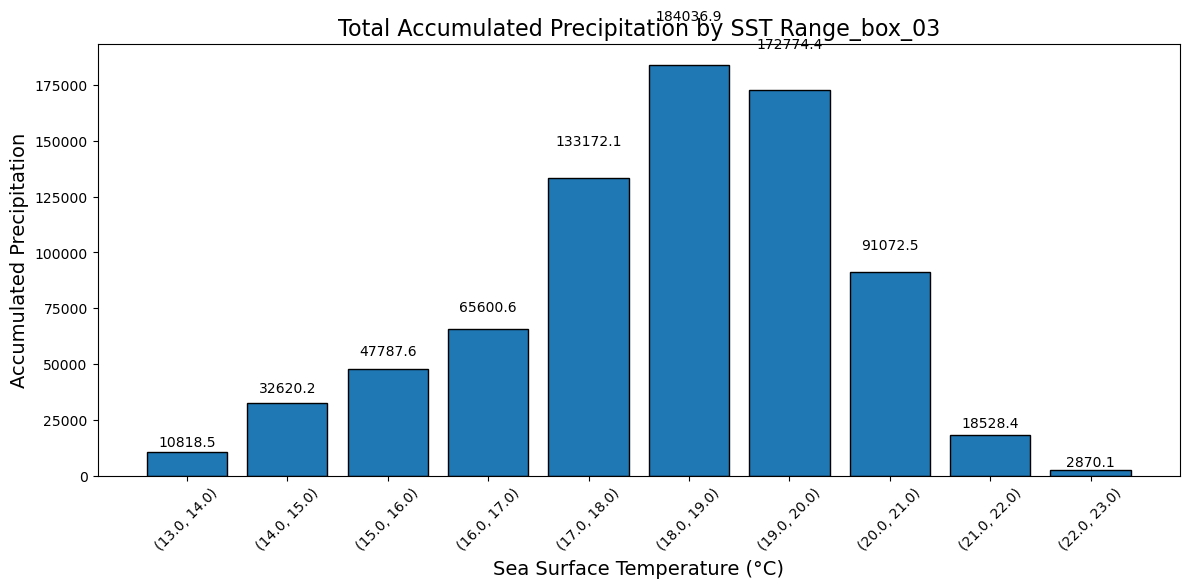

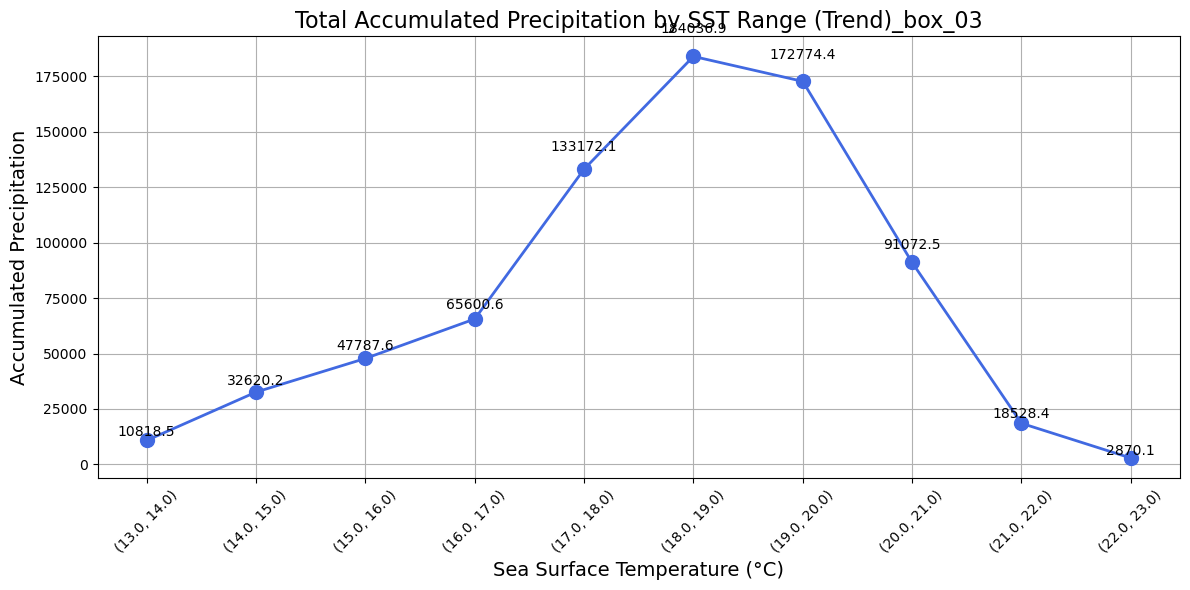

In [93]:
bar_plot(accumulated_precip_box_03, bin_labels, 'box_03')

/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/3067063048.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/3067063048.py:2: FutureWarning: The provided callable <function std at 0x106e28040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_17415/3067063048.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bin_


Detailed Statistics for Each SST Bin:
        SST_bin            sum      mean   count       max       std
0  (13.0, 14.0)   10818.477295  0.117199   92309  4.984360  0.422889
1  (14.0, 15.0)   32620.239260  0.123795  263502  5.354556  0.421271
2  (15.0, 16.0)   47787.597818  0.255474  187055  5.486911  0.679603
3  (16.0, 17.0)   65600.623212  0.509128  128849  5.549504  0.966994
4  (17.0, 18.0)  133172.107690  0.955488  139376  5.842718  1.266569
5  (18.0, 19.0)  184036.873934  1.276633  144158  6.090167  1.393577
6  (19.0, 20.0)  172774.353625  1.442888  119742  5.847289  1.429673
7  (20.0, 21.0)   91072.498732  1.412305   64485  5.441313  1.395488
8  (21.0, 22.0)   18528.380887  1.350662   13718  5.313520  1.413936
9  (22.0, 23.0)    2870.121957  1.625211    1766  5.419461  1.542506


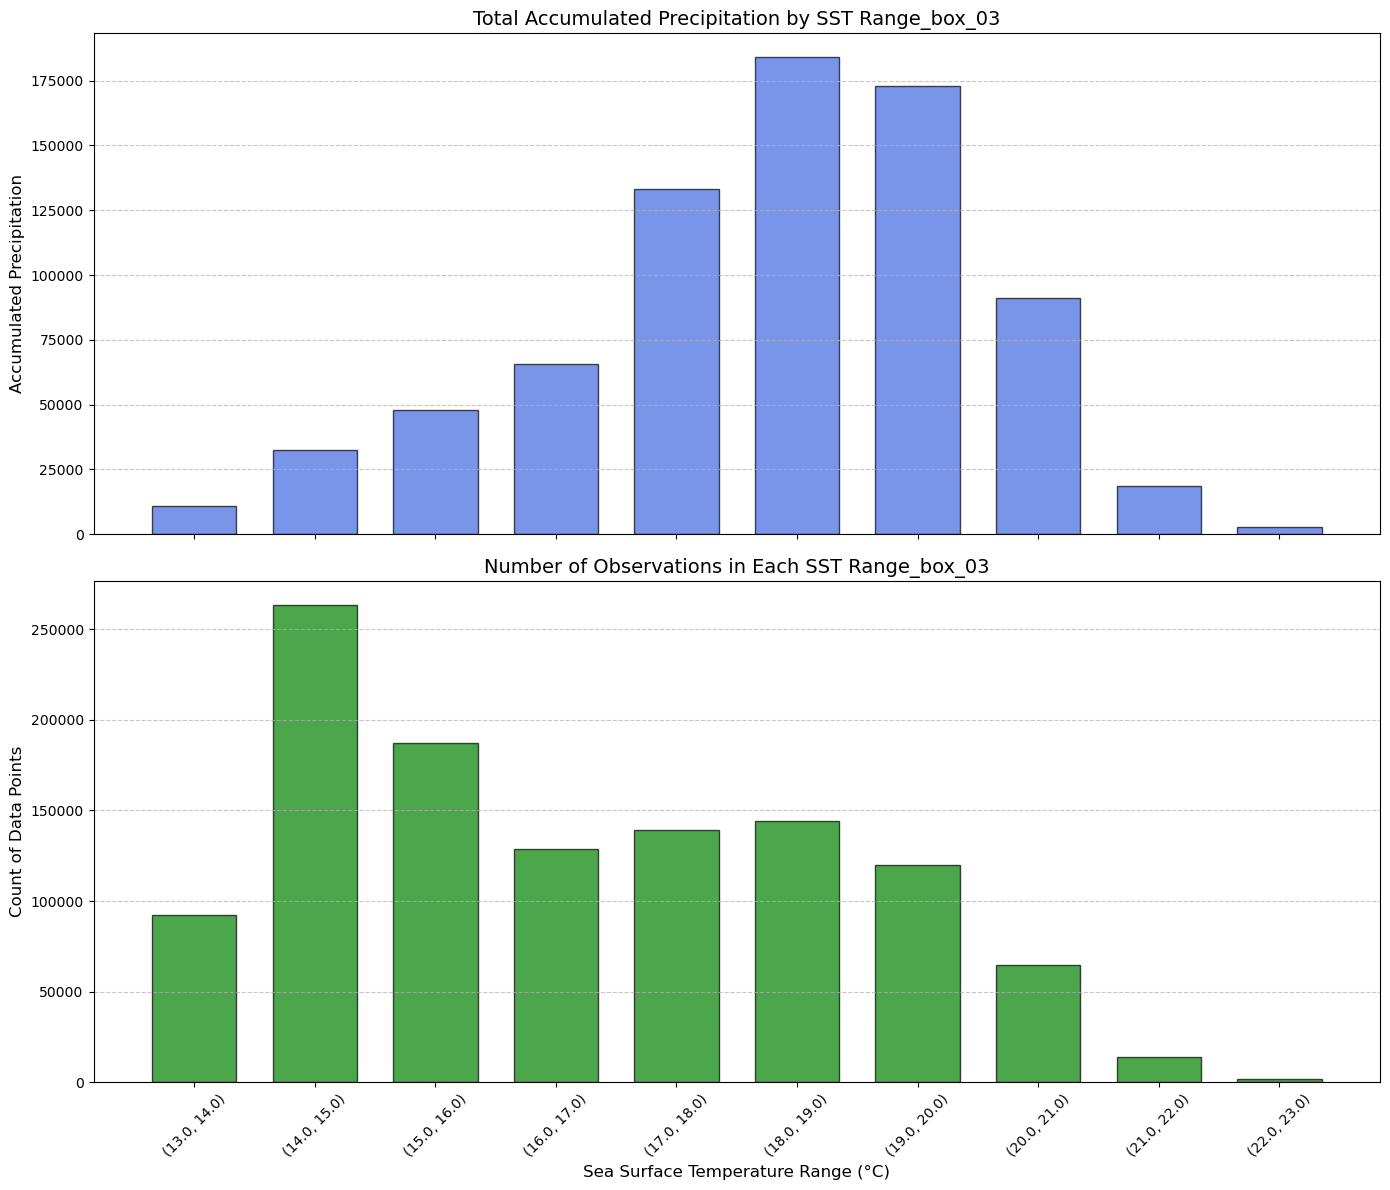

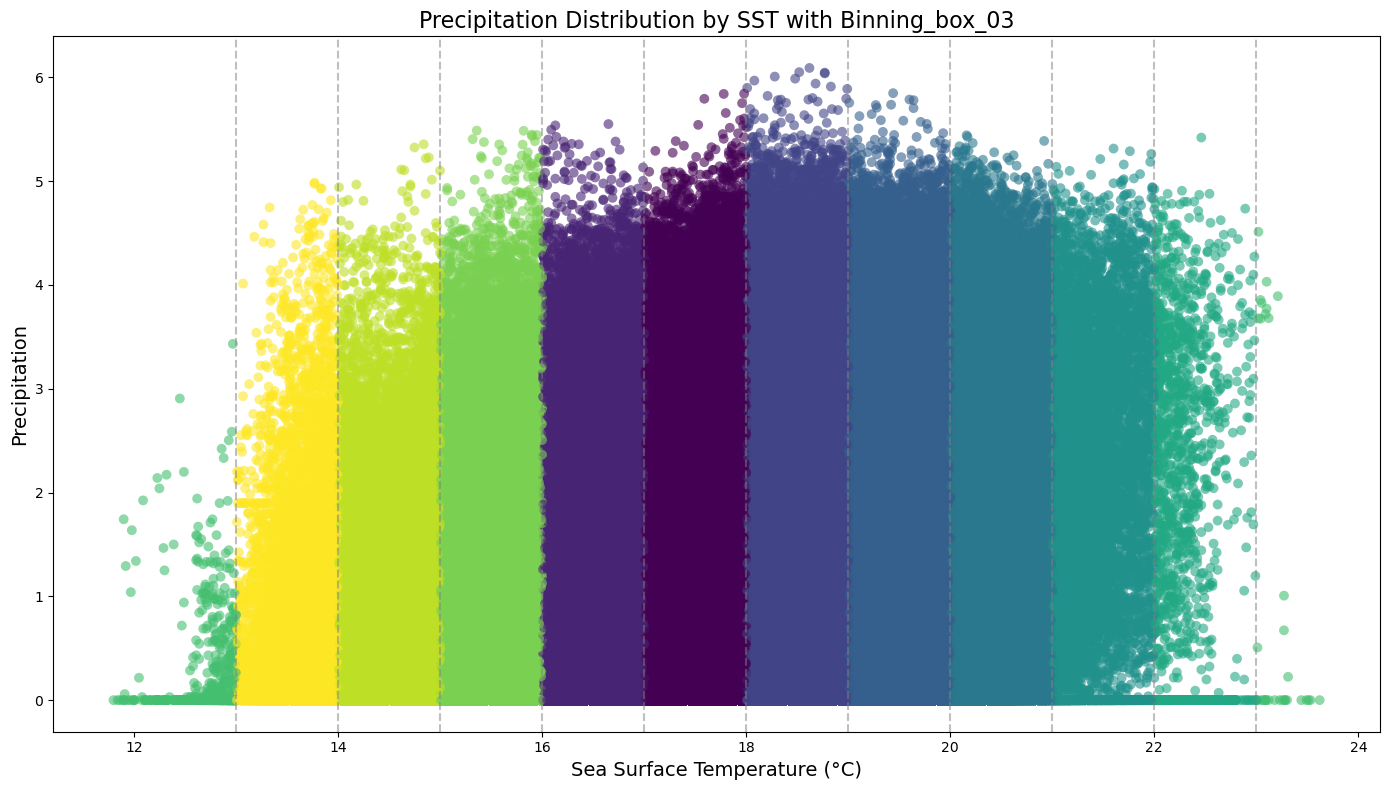

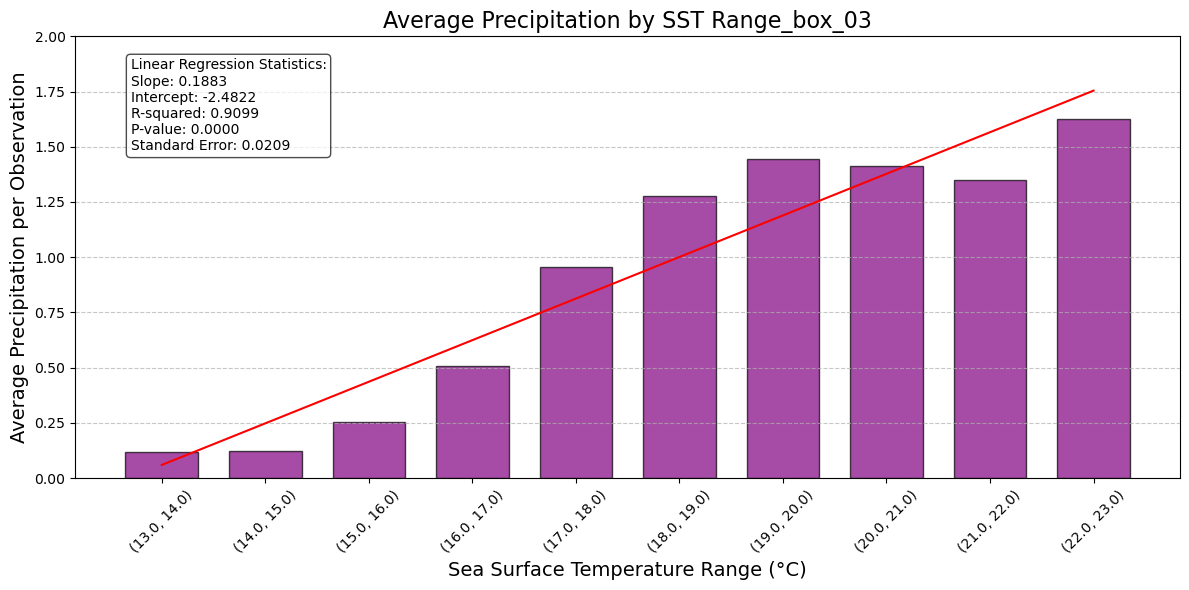

In [94]:
statistical_analysis_plot(data_box_03, accumulated_precip_box_03, sst_bins, 'box_03')